# Описание проекта

Объект проекта - стартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользовател мобильного приложения, изучить воронку продаж, Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

Задача: Выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

# Описание данных

Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [22]:
import pandas as pd 
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from plotly import graph_objects as go
import math as mth

## Шаг 1. Изучим общую информацию

In [23]:
df=pd.read_csv('/Users/z/Downloads/logs_exp.csv', sep='\t') #импортируем данные с разделителем \t

display(df.head(3))
display(df.info())
display(df.isna().sum()) #проверяем на нулевые значения
column_name = ['EventName',	'ExpId'] #изучаем интересующие столбцы на уникальные значения
for i in column_name:
    print('Уникальные значения столбца',i)
    display(df[i].unique())  

print('Кол-во дубликатов', df.duplicated().sum())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Уникальные значения столбца EventName


array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Уникальные значения столбца ExpId


array([246, 248, 247])

Кол-во дубликатов 413


## Шаг 2. Подготовим данные
- Заменим названия столбцов;
- Проверим пропуски и типы данных;
- Добавим столбец даты и времени, и отдельный столбец дат;

In [24]:
df.columns=['event', 'id', 'timestamp', 'group'] #переименуем название колонок
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s') #выделяем дату и время из timestamp
df['date'] = df['datetime'].dt.date #выделяем отдельно дату из timestamp
df = df.drop('timestamp', 1) #удаляем timestamp заненадобностью
df = df.drop_duplicates().reset_index(drop=True) #удаляем дубликаты
def aab(group):
    if group==246:
        return 'A1'
    elif group==247:
        return 'A2'
    else:
        return 'B'
df['group'] = df['group'].apply(aab) #заменяем названия групп для удобства чтения на А1, А2 и В
df['date'] = df['date'].astype('datetime64') #преобразуем формат даты
display(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     243713 non-null  object        
 1   id        243713 non-null  int64         
 2   group     243713 non-null  object        
 3   datetime  243713 non-null  datetime64[ns]
 4   date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


None

,event,id,group,datetime,date
0,MainScreenAppear,4575588528974610257,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25


# Вывод:
При предварительной проверке данных из 244126 выявлено 413 дубликатов. В остальном данные чистые, пропусков не обнаружено.

## Шаг 3. Изучим и проверим данные

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период располагаем?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверим, что есть пользователи из всех трёх экспериментальных групп.

Количество событий = 243713
Виды уникальных событий: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
Количество уникальных событий = 5
Количество уникальных пользователей = 7551
Среднее число событий на пользователя = 20
Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


,id,event
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


<AxesSubplot:>

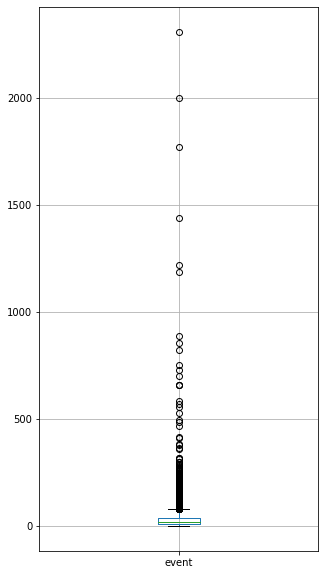

In [25]:
print('Количество событий =', df['event'].count())
print('Виды уникальных событий:', df['event'].unique()) 
print('Количество уникальных событий =', len(df['event'].unique()))
print('Количество уникальных пользователей =', len(df['id'].unique()))
print('Среднее число событий на пользователя =', round(df.groupby('id')['event'].count().median()))
print('Минимальная дата:', df['date'].min())
print('Максимальная дата:', df['date'].max())

users_by_event_count = df.groupby('id')['event'].count().reset_index()
display(users_by_event_count.describe())

plt.figure(figsize=(5,10))
users_by_event_count.boxplot(column=['event'])

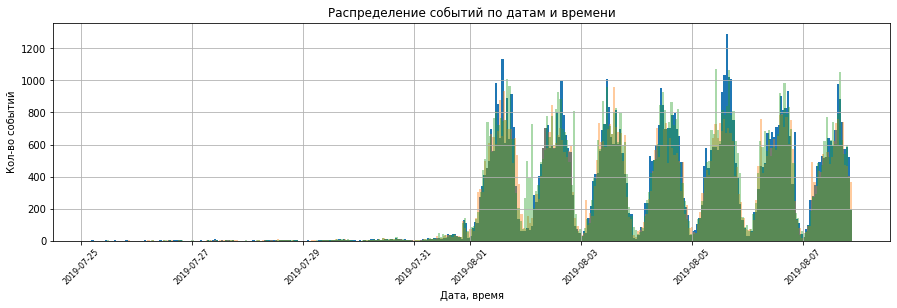

In [26]:
plt.figure(figsize=(15,4))
plt.hist(df[df['group']== 'A1']['datetime'], bins=336)
plt.hist(df[df['group']== 'A2']['datetime'], bins=336, alpha=0.4)
plt.hist(df[df['group']== 'B']['datetime'], bins=336, alpha=0.4);
plt.xticks(fontsize=8,rotation=45);
plt.ylabel('Кол-во событий')
plt.xlabel('Дата, время')
plt.grid()
plt.title('Распределение событий по датам и времени');

In [27]:
df = df[df['date'] > '2019-07-31']
print('Количество событий =', df['event'].count())
print('Количество уникальных пользователей =', len(df['id'].unique()))
print('После отсева мы потеряли', 243713 - df['event'].count(), 'события -', ((243713 - df['event'].count())/2437.13).round(1),'%') 
print('И', 7551 - len(df['id'].unique()), 'уникальных пользователей -', round(17/75.51,1),'%')



Количество событий = 240887
Количество уникальных пользователей = 7534
После отсева мы потеряли 2826 события - 1.2 %
И 17 уникальных пользователей - 0.2 %


In [28]:
df.groupby('group')['id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: id, dtype: int64

# Вывод: 

- Сбор данных о событиях явно начался с 1 августа, событий стало много и появилась цикличность от времени суток. Итог: мы располагаем только 1 неделей данных c 01.08.2019 по 07.08.2019.
- После отсева мы потеряли 1,2% событий и 0,2% пользователей, отсев незначительный.
- В тесте участвовали пользователи из всех групп, их количество примерно идентично.

## Шаг 4. Изучим воронку событий

### 4.1 Какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [29]:
print('Виды уникальных событий:', df['event'].unique());
print('События по частоте:')
display(df.groupby('event')['id'].count().sort_values(ascending = False));

Виды уникальных событий: ['Tutorial' 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear'
 'PaymentScreenSuccessful']
События по частоте:


event
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: id, dtype: int64

### 4.2 Сколько пользователей совершали каждое из этих событий? Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [30]:
events_id = df.groupby('event').agg({'event':'count', 'id':'nunique'}).sort_values(by='id', ascending=False)
events_id.columns = ['count_event', 'count_unique_users']
events_id['one_time_event_persent'] = (events_id['count_unique_users'] / df['id'].nunique()* 100).round(1) # доля хотя бы раз совершивших событие
display(events_id)

,count_event,count_unique_users,one_time_event_persent
event,,,
MainScreenAppear,117328,7419,98.5
OffersScreenAppear,46333,4593,61.0
CartScreenAppear,42303,3734,49.6
PaymentScreenSuccessful,33918,3539,47.0
Tutorial,1005,840,11.1


### 4.3 Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? 

4 из 5 событий имеют логическую последовательность: MainScreenAppear - зашел на главный экран, OffersScreenAppear - зашел на экран товара, CartScreenAppear - зашел в корзину, PaymentScreenSuccessful - произвел оплату. Tutorial часто пропускают, поэтому количество таких событий незначительно.

###  4.4 По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [31]:
fig = go.Figure(
    go.Funnel(
        y=[
            'MainScreenAppear',
            'OffersScreenAppear',
            'CartScreenAppear',
            'PaymentScreenSuccessful',
        ],
        x=[7419, 4593, 3734, 3539],
    )
)
fig.show()

А теперь то же самое, но вручную. 

In [32]:
user_count_by_events = df.groupby('event')['id'].nunique().sort_values(ascending=False)
display(user_count_by_events)
print('Конверсия события 1 к событию 2 = ', (user_count_by_events['OffersScreenAppear']/user_count_by_events['MainScreenAppear']*100).round(1),'%')
print('Конверсия события 2 к событию 3 = ', (user_count_by_events['CartScreenAppear']/user_count_by_events['OffersScreenAppear']*100).round(1),'%')
print('Конверсия события 3 к событию 4 = ', (user_count_by_events['PaymentScreenSuccessful']/user_count_by_events['CartScreenAppear']*100).round(1),'%')
print('Конверсия события 1 к событию 4 = ', (user_count_by_events['PaymentScreenSuccessful']/user_count_by_events['MainScreenAppear']*100).round(1),'%')

event
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: id, dtype: int64

Конверсия события 1 к событию 2 =  61.9 %
Конверсия события 2 к событию 3 =  81.3 %
Конверсия события 3 к событию 4 =  94.8 %
Конверсия события 1 к событию 4 =  47.7 %


# Вывод:
Больше всего пользователей теряется при переходе от события 1 к событию 2, от главного экрана к экрану товара перешло  61,9%. От события 2 к событию 3 с экрана предложения в корзину переходит 81,3%. От события 3 к 4: от корзины к удачной оплате 94,8%. Итого к финальной покупке от 1 события к 4 приходит 47,7% пользователей.

## Шаг 5. Изучаем результаты эксперимента

### 5.1 Сколько пользователей в каждой экспериментальной группе?

In [33]:
print('Уникальных пользователей в каждой жкспериментальной группе:', df.groupby('group')['id'].nunique())
print('Уникальных пользователей в сумме:', df.groupby('group')['id'].nunique().sum())

Уникальных пользователей в каждой жкспериментальной группе: group
A1    2484
A2    2513
B     2537
Name: id, dtype: int64
Уникальных пользователей в сумме: 7534


### 5.2 Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверяем, находят ли статистические критерии разницу между выборками 246 и 247.

Формулируем нулевую гипотезу: доли, проверяемых групп равны. Альтернативная гипотеза: доли не равны.

In [34]:
successes_test = df[df['event']!='Tutorial'].pivot_table(index='event', columns='group', values='id', aggfunc='nunique').sort_values(by='A1', ascending=False).reset_index()
trials_test = df.groupby('group')['id'].nunique()
display(successes_test)
display(trials_test)

group,event,A1,A2,B
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


group
A1    2484
A2    2513
B     2537
Name: id, dtype: int64

In [35]:
alpha = 0.05

for i in successes_test.index:

    p1 = successes_test.loc[i]['A1']/trials_test['A1']
    p2 = successes_test.loc[i]['A2']/trials_test['A2']
    p_combined = (successes_test.loc[i]['A1'] + successes_test.loc[i]['A2']) / (trials_test['A1'] + trials_test['A2'])
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_test['A1'] + 1/trials_test['A2']))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


# Вывод:
p-value значительно больше 0,05, подтверждаем, что статистические критерии не находят разницы между выборками.

### 5.3 Выберем самое популярное событие. 

#### Формируем датасет с суммарными значениями по количеству пользователей в каждой группе

In [36]:
#формируем датасет с суммарными значениями по количеству пользователей в каждой группе
users_total = df.groupby('group')['id'].nunique()
users_total['A1+A2'] = users_total['A1'] + users_total['A2']
users_total['total'] = users_total['A1+A2'] + users_total['B']
display(users_total) 

group
A1       2484
A2       2513
B        2537
A1+A2    4997
total    7534
Name: id, dtype: int64

#### Формируем датасет с остальными данными: суммы уникальных пользователей по каждому событий в каждой группе и процентные соотношения

In [37]:
event_data = df[df['event']!='Tutorial'].pivot_table(index='event', columns='group', values='id', aggfunc='nunique').sort_values(by='A1', ascending=False).reset_index()
event_data['A1+A2'] = event_data['A1'] + event_data['A2']
event_data = event_data[['event', 'A1', 'A2', 'A1+A2', 'B']]#поменял порядок столбцов для удобства чтения финальной таблицы
event_data['total_true'] = event_data['A1+A2'] + event_data['B']
event_data['persent_A1'] = (event_data['A1']/users_total['A1']*100).round(1)
event_data['persent_A2'] = (event_data['A2']/users_total['A2']*100).round(1)
event_data['persent_A1+A2'] = (event_data['A1+A2']/users_total['A1+A2']*100).round(1)
event_data['persent_B'] = (event_data['B']/users_total['B']*100).round(1)
event_data['persent_total'] = (event_data['total_true']/users_total['total']*100).round(1)
display(event_data)

group,event,A1,A2,A1+A2,B,total_true,persent_A1,persent_A2,persent_A1+A2,persent_B,persent_total
0,MainScreenAppear,2450,2476,4926,2493,7419,98.6,98.5,98.6,98.3,98.5
1,OffersScreenAppear,1542,1520,3062,1531,4593,62.1,60.5,61.3,60.3,61.0
2,CartScreenAppear,1266,1238,2504,1230,3734,51.0,49.3,50.1,48.5,49.6
3,PaymentScreenSuccessful,1200,1158,2358,1181,3539,48.3,46.1,47.2,46.6,47.0


#### Проверяем, есть ли статистическое отличие между каждой из указанных групп(A1, A2, A1+A2) с группой B

- Формулируем нулевые гипотезы по каждому из 3х тестов: доли пользователей, совершивших каждое из 4х событий из групп A1, A2, A1+A2 не имеют статистических отличий от долей пользователей, совершивших событие в группе B.
- Альтернативная гипотеза: доли имеют статистические отличия.

In [38]:
pvalue_results = {'event': ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'], 
                  'A1': [0, 0, 0, 0], 
                  'A2': [0, 0, 0, 0], 
                  'A1+A2': [0, 0, 0, 0]} 
pvalue_results = pd.DataFrame(pvalue_results) 

print('P-value по каждой из групп сравнения с группой B:')
#alpha = 0.05
for i in event_data.index:
    for j in ['A1', 'A2', 'A1+A2']:
        p1 = event_data.loc[i][j]/users_total.loc[j] # пропорция успехов в первой группе
        p2 = event_data.loc[i]['B']/users_total['B'] # пропорция успехов во второй группе
        p_combined = (event_data.loc[i][j] + event_data.loc[i]['B'] ) / (users_total.loc[j] + users_total['B']) # пропорция успехов в комбинированном датасете:
        difference = p1 - p2 # разница пропорций в датасетах
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_total.loc[j] + 1/users_total['B']))
        distr = st.norm(0, 1)# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        pvalue_results.loc[i,j] = p_value

display(pvalue_results)

P-value по каждой из групп сравнения с группой B:


,event,A1,A2,A1+A2
0,MainScreenAppear,0.294972,0.458705,0.294245
1,OffersScreenAppear,0.208362,0.919782,0.434255
2,CartScreenAppear,0.078429,0.578620,0.181759
3,PaymentScreenSuccessful,0.212255,0.737342,0.600429


# Вывод:
В рамках A/A/В теста мы провели 12 основных и 4 тестовых проверки между контрольными группами. 
В результате A/A/B теста при коэффициенте значимости 0.05 статистически значимой разницы между группами не выявлено. При коэффициенте значимости 0.1 выпадает лишь одно значение по событию CartScreenAppear в тесте A1/B, что говорит о возможности в 1 случае из 10 получить не верный результат. Остановимся на уровне значимости в 0.05. 

Можно утверждать, что изменение шрифта не оказало эффекта на поведение пользователей.

# Общий вывод:

- При предварительной проверке данных из 244126 выявлено 413 дубликатов
- При подготовке данных мы привели датафрейм к удобочитаемому виду, выделили дату и время событий, удалили лишние данные и дубликаты, переименовали группы для удобства исследования в А1, А2 и В, преобразовали форматы данных
- Количество событий в исследовании = 243713
- Количество уникальных событий 5: 'MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear', 'OffersScreenAppear' и 'Tutorial'
- Количество уникальных пользователей = 7551
- Среднее число событий на пользователя = 32
- Минимальная дата: 2019-07-25 00:00:00
- Максимальная дата: 2019-08-07 00:00:00
- Из распределения событий по дате и времени делаем вывод, что сбор данных о событиях явно начался не с минимальной даты, а с 1 августа, когда событий стало много и появилась цикличность от времени суток. Итог: мы располагаем только 1 неделей данных c 01.08.2019 по 07.08.2019. Первую неделю данных отсеиваем. После отсева мы потеряли 2826 события - 1.2% и 17 уникальных пользователей - 0.2%. Отсев незначительный.
- Воронка: Больше всего пользователей теряется при переходе от события 1 к событию 2, от главного экрана к экрану товара перешло  61,9%. От события 2 к событию 3 с экрана предложения в корзину переходит 81,3%. От события 3 к 4: от корзины к удачной оплате 94,8%. Итого к финальной покупке от 1 события к 4 приходит 47,7% пользователей.
- Проверили количество уникальных пользователей по группам: A1 - 2484, A2 - 25136 B - 2537. Их число примерно идентично, группы равноправные.
- Проверили гипотезу нулевую гипотезу о равенстве выборок двух контрольных групп А1 и А2. Статистически выборки равны.
- В результате A/A/B теста при коэффициенте значимости 0.05 статистически значимой разницы между группами не выявлено. При коэффициенте значимости 0.1 выпадает лишь одно значение по событию CartScreenAppear в тесте A1/B, что говорит о возможности в 1 случае из 10 получить не верный результат. Остановимся на уровне значимости в 0.05. 

- Можно утверждать, что изменение шрифта не оказало эффекта на поведение пользователей.